In [325]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from itertools import product
from sklearn.model_selection import StratifiedKFold
import optuna

In [98]:
frb_data = pd.read_csv('frb-data.csv')
frb_data['Repeater'] = frb_data['Repeater'].map({'Yes': 1, 'No': 0})
frb_data['Repeater'] = frb_data['Repeater'].fillna(0)
frb_data['Repeater'] = frb_data['Repeater'].astype(int)

In [99]:
# Select numerical columns that are relevant for VAE training
# features = ['Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'DM_SNR', 'DM_SNR_err', 'DM_alig', 'DM_alig_err', 'Flux_density', 
#             'Flux_density_err', 'Width', 'Width_err', 'Freq_high', 'Freq_low', 'Freq_peak', 'Fluence', 'Fluence_err', 'Energy', 
#             'Energy_err', 'Polar_l', 'Polar_l_err', 'Polar_c', 'Polar_c_err', 'RM_syn', 'RM_syn_err', 'RM_QUfit', 'RM_QUfit_err', 'Scatt_t', 'Scatt_t_err', 'Scin_f', 'Scin_f_err',]

labels = frb_data['Repeater']

# Function to clean numerical strings and convert to float
def clean_numeric_value(value):
    if isinstance(value, str):
        value = value.strip()
        if not value:
            return np.nan
        try:
            # Remove special characters and split if necessary
            for char in ['/', '+', '<', '>', '~']:
                value = value.replace(char, '')
            if '-' in value:
                value = value.split('-')[0]
            return float(value)
        except ValueError:
            return np.nan
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan
    
error_features = [
    'DM_SNR', 'DM_alig', 'Flux_density', 'Width', 'Fluence', 'Energy',
    'Polar_l', 'Polar_c', 'RM_syn', 'RM_QUfit', 'Scatt_t', 'Scin_f'
]
base_features = [
    'Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'Freq_high',
    'Freq_low', 'Freq_peak', 'Repeater'
]

for feature in base_features + error_features:
    frb_data[feature] = frb_data[feature].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_err'] = frb_data[f'{feature}_err'].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_upper'] = frb_data[feature] + frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[feature] - frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[f'{feature}_lower'].clip(lower=0)

features = (
    base_features +
    error_features +
    [f'{feature}_upper' for feature in error_features] +
    [f'{feature}_lower' for feature in error_features]
)

In [100]:
frb_data_clean = frb_data[features].fillna(0)
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

# Retain the original indices
indices = frb_data_clean.index

# Split the data and retain indices
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [101]:
class SupervisedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3, activation=nn.LeakyReLU(0.1)):
        super(SupervisedVAE, self).__init__()
        
        self.activation = activation
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate)
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )
        
        # Classification head for binary classification
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        class_prob = self.classifier(z)
        return recon_x, mu, logvar, class_prob

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = frb_data_scaled.shape[1]
hidden_dim = 256
latent_dim = 10
patience = 4
num_epochs = 150

In [103]:
reconstruction_loss_fn = nn.MSELoss(reduction='sum')
classification_loss_fn = nn.BCELoss()

def loss_function(recon_x, x, mu, logvar, class_prob, labels, beta, gamma):
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = classification_loss_fn(class_prob, labels.unsqueeze(1).float())
    total_loss = recon_loss + beta * kl_loss + gamma * class_loss
    return total_loss, recon_loss, kl_loss, class_loss



In [113]:
def train_supervised(model, optimizer, scheduler, epoch, beta, gamma):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        # if batch_idx % 100 == 0:
        #     print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
        #           f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised(model, scheduler, optimizer, epoch, beta, gamma):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False



In [282]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    false_positives = np.sum((all_labels == 0) & (all_preds == 1))

    return accuracy, class_report, conf_matrix, f1, false_positives  # Return F1 score as well


In [114]:
# dropout_rate = 0.3
# learning_rate = 1e-3

# # check different activation functions
# dropout_rate = 0.3
# learning_rate = 1e-3

# # Define parameter grid
# param_grid = {
#     "hidden_dim": [128, 256],
#     "latent_dim": [5, 10, 20],
#     "beta": [0.5, 1, 2],
#     "gamma": [0.5, 1, 2],
#     "activation": [nn.ReLU(), nn.LeakyReLU(0.1), nn.ELU(), nn.SELU(), nn.GELU()],
#     "dropout_rate": [0.1, 0.3, 0.5]
# }

# best_f1_score = 0
# best_accuracy = 0
# best_params = {}

# # Iterate over all combinations of hyperparameters
# for hidden_dim, latent_dim, beta, gamma, activation, dropout_rate in product(
#     param_grid["hidden_dim"],
#     param_grid["latent_dim"],
#     param_grid["beta"],
#     param_grid["gamma"],
#     param_grid["activation"],
#     param_grid["dropout_rate"]
# ):
#     # Initialize model with current hyperparameters
#     model = SupervisedVAE(input_dim, hidden_dim, latent_dim, dropout_rate, activation=activation).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)
#     val_losses = []
    
#     patience = 4
#     num_epochs = 50 
    
#     for epoch in range(1, num_epochs + 1):
#         train_loss, _, _, _, _ = train_supervised(model, optimizer, scheduler, epoch, beta, gamma)
#         val_loss, _, _, _, val_accuracy = validate_supervised(model, optimizer, scheduler, epoch, beta, gamma)
#         val_losses.append(val_loss)

#         scheduler.step(val_loss)
        
#         if early_stopping(val_losses, patience):
#             print(f"Early stopping triggered at epoch {epoch}")
#             break

#     val_accuracy, val_class_report, val_conf_matrix, val_f1_score = evaluate_classifier(model, val_loader, device)

#     # Check if this is the best model so far
#     if val_accuracy > best_accuracy:
#         best_accuracy = val_accuracy
#         best_params = {
#             "hidden_dim": hidden_dim,
#             "latent_dim": latent_dim,
#             "beta": beta,
#             "gamma": gamma,
#             "activation": activation,
#             "dropout_rate": dropout_rate
#         }

# print("Best Accuracy:", best_accuracy)
# print("Best Parameters:", best_params)

In [283]:
def get_activation_function(name):
    if name == 'ReLU':
        return nn.ReLU()
    elif name == 'LeakyReLU':
        return nn.LeakyReLU(0.1)
    elif name == 'ELU':
        return nn.ELU()
    elif name == 'SELU':
        return nn.SELU()
    elif name == 'GELU':
        return nn.GELU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 128, 512)
    latent_dim = trial.suggest_int('latent_dim', 5, 20)
    beta = trial.suggest_float('beta', 0.5, 2.0)
    gamma = trial.suggest_float('gamma', 0.5, 2.0)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    activation_name = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU', 'SELU', 'GELU'])
    activation = get_activation_function(activation_name)

    model = SupervisedVAE(input_dim, hidden_dim, latent_dim, dropout_rate, activation).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)
    
    for epoch in range(1, 30):  # Use a smaller number of epochs for faster optimization
        train_loss, _, _, _, _ = train_supervised(model, optimizer, scheduler, epoch, beta, gamma)
        val_loss, _, _, _, val_accuracy = validate_supervised(model, optimizer, scheduler, epoch, beta, gamma)
        scheduler.step(val_loss)
    
    # Evaluate model performance
    val_accuracy, _, _, val_f1_score, val_false_positives = evaluate_classifier(model, val_loader, device)
    
    min_false_positives = 10
    
    if val_false_positives < min_false_positives:
        penalty = (min_false_positives - val_false_positives) * 0.1
        return val_accuracy - penalty
    else:
        return val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best Hyperparameters:", study.best_params)

[I 2024-11-07 23:21:14,678] A new study created in memory with name: no-name-ff21b17f-2b60-434d-a6f1-83c0327d83bd
[I 2024-11-07 23:21:24,938] Trial 0 finished with value: 0.9203693017888055 and parameters: {'hidden_dim': 260, 'latent_dim': 20, 'beta': 1.959155584198522, 'gamma': 1.335607690291924, 'dropout_rate': 0.34198765174414414, 'activation': 'SELU'}. Best is trial 0 with value: 0.9203693017888055.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-11-07 23:21:35,337] Trial 1 finished with value: 0.9786497403346798 and parameters: {'hidden_dim': 404, 'latent_dim': 19, 'beta': 0.8439090198280703, 'gamma': 1.639517947471103, 'dropout_rate': 0.24901581919929516, 'activation': 'LeakyReLU'}. Best is trial 1 with value: 0.9786497403346798.
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packag

Best Hyperparameters: {'hidden_dim': 305, 'latent_dim': 12, 'beta': 0.9164602936066939, 'gamma': 0.9210066688221937, 'dropout_rate': 0.12973559985051597, 'activation': 'GELU'}


In [284]:
best_params = study.best_params

beta = best_params["beta"]
gamma = best_params["gamma"]
num_epochs = 150
patience = 4

best_params

{'hidden_dim': 305,
 'latent_dim': 12,
 'beta': 0.9164602936066939,
 'gamma': 0.9210066688221937,
 'dropout_rate': 0.12973559985051597,
 'activation': 'GELU'}

In [285]:
best_model = SupervisedVAE(input_dim, best_params["hidden_dim"], best_params["latent_dim"], best_params["dropout_rate"], activation=get_activation_function(best_params["activation"])).to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved with validation loss: 22.5908
New best model saved with validation accuracy: 0.9365
New best model saved with validation loss: 19.9784
New best model saved with validation accuracy: 0.9538
New best model saved with validation loss: 18.3518
New best model saved with validation accuracy: 0.9596
New best model saved with validation loss: 16.1346
New best model saved with validation accuracy: 0.9613
New best model saved with validation accuracy: 0.9700
New best model saved with validation loss: 15.6040
New best model saved with validation loss: 14.8501
New best model saved with validation accuracy: 0.9775
New best model saved with validation loss: 14.6556
New best model saved with validation loss: 13.8118
New best model saved with validation loss: 13.5027
New best model saved with validation accuracy: 0.9786
New best model saved with validation loss: 12.9584
New best model saved with validation loss: 12.7392
New best model saved with validation accuracy: 0.9810
New bes

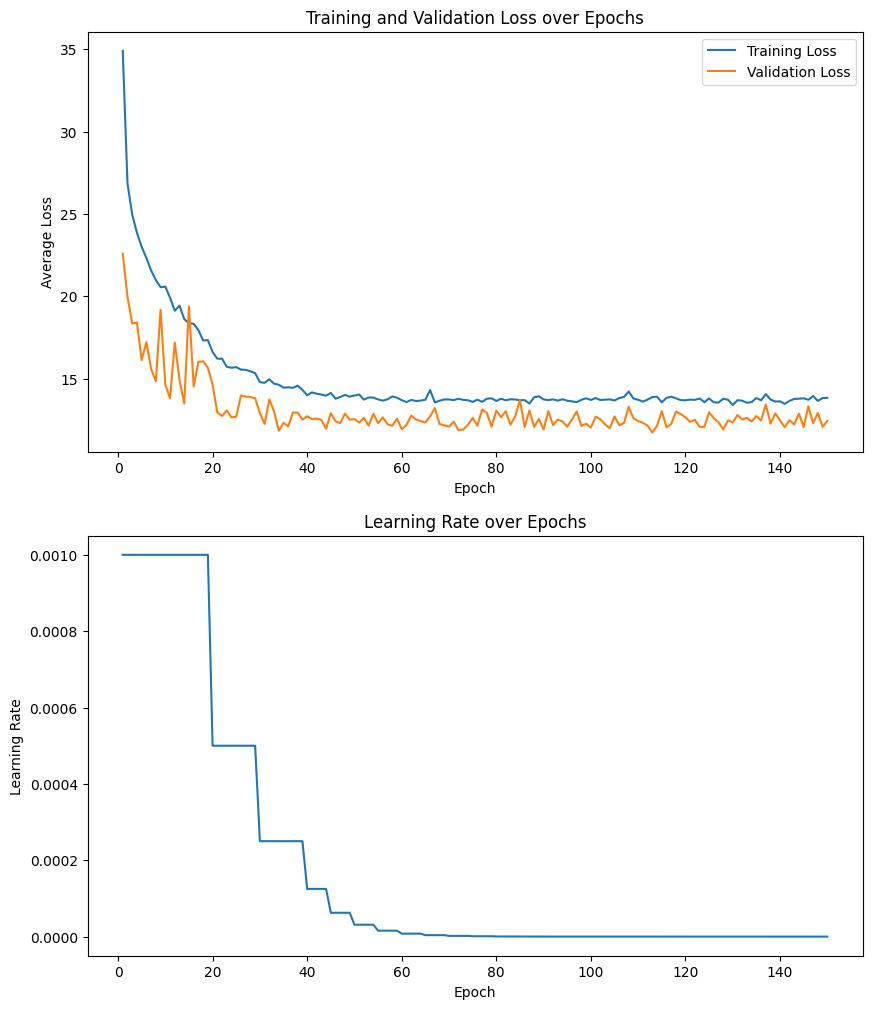

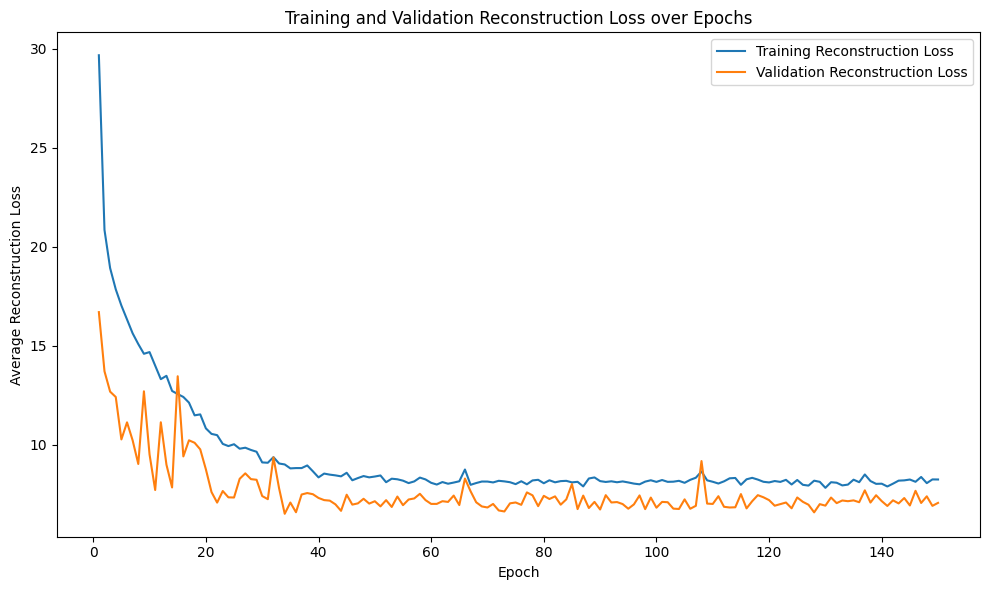

In [286]:
best_train_losses = []
best_val_losses = []
best_train_recon_losses = []
best_val_recon_losses = []
best_train_kl_losses = []
best_val_kl_losses = []
best_train_class_losses = []
best_val_class_losses = []
best_val_accuracies = []
best_learning_rates = []

best_best_loss = float('inf')
best_best_val_accuracy = 0


for epoch in range(1, num_epochs + 1):
    # Training step
    train_loss, train_recon, train_kl, train_class, train_accuracy = train_supervised(best_model, optimizer, scheduler, epoch, beta, gamma)
    
    # Validation step
    val_loss, val_recon, val_kl, val_class, val_accuracy = validate_supervised(best_model, optimizer, scheduler, epoch, beta, gamma)
    
    # Track losses and accuracy
    best_train_losses.append(train_loss)
    best_val_losses.append(val_loss)
    best_train_recon_losses.append(train_recon)
    best_val_recon_losses.append(val_recon)
    best_train_kl_losses.append(train_kl)
    best_val_kl_losses.append(val_kl)
    best_train_class_losses.append(train_class)
    best_val_class_losses.append(val_class)
    best_val_accuracies.append(val_accuracy)
    best_learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Scheduler step
    scheduler.step(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_best_loss:
        best_best_loss = val_loss
        torch.save(best_model.state_dict(), 'best_supervised_vae_best_loss.pth')
        print(f"New best model saved with validation loss: {best_best_loss:.4f}")
    
    # Save the best model based on validation accuracy
    if val_accuracy > best_best_val_accuracy:
        best_best_val_accuracy = val_accuracy
        torch.save(best_model.state_dict(), 'best_supervised_vae_best_acc.pth')
        print(f"New best model saved with validation accuracy: {best_best_val_accuracy:.4f}")
    
    # Early stopping
    if early_stopping(best_val_losses, patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break
    

print("Training complete.")

# Plot training and validation loss, learning rates, and reconstruction loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot training and validation loss
ax1.plot(range(1, len(best_train_losses) + 1), best_train_losses, label='Training Loss')
ax1.plot(range(1, len(best_val_losses) + 1), best_val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss')
ax1.legend()

# Plot learning rate
ax2.plot(range(1, len(best_learning_rates) + 1), best_learning_rates)
ax2.set_title('Learning Rate over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')

# Plot the training and validation reconstruction loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(1, len(best_train_recon_losses) + 1), best_train_recon_losses, label='Training Reconstruction Loss')
ax.plot(range(1, len(best_val_recon_losses) + 1), best_val_recon_losses, label='Validation Reconstruction Loss')
ax.set_title('Training and Validation Reconstruction Loss over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Reconstruction Loss')
ax.legend()

plt.tight_layout()
plt.show()


In [288]:
val_accuracy, val_class_report, val_conf_matrix, val_f1_score, fp = evaluate_classifier(best_model, val_loader, device)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)
print(f"Validation F1 Score: {val_f1_score:.4f}")

Validation Accuracy: 0.9786
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.91      0.93      0.92       238
    Repeater       0.99      0.99      0.99      1495

    accuracy                           0.98      1733
   macro avg       0.95      0.96      0.96      1733
weighted avg       0.98      0.98      0.98      1733

Confusion Matrix:
 [[ 222   16]
 [  21 1474]]
Validation F1 Score: 0.9787


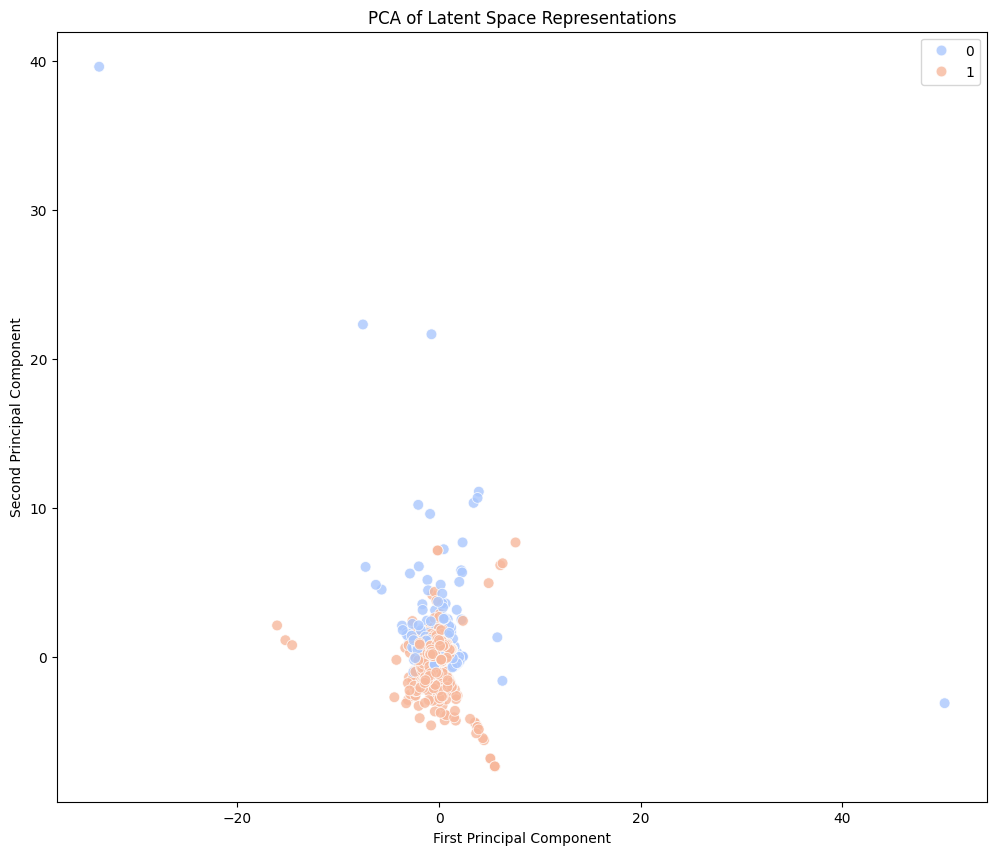

In [122]:
def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latent_representations.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(latent_representations), np.concatenate(all_labels)


def visualize_latent_space_pca(latent_representations, labels, model, device):
    # Perform PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    # Plot the 2D latent space
    plt.figure(figsize=(12, 10))
    #scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='plasma', s=10)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8)
    plt.title('PCA of Latent Space Representations')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

train_latent, train_labels_np = get_latent_representations(best_model, train_loader, device)
visualize_latent_space_pca(train_latent, train_labels_np, best_model, device)

In [289]:
def evaluate_classifier_full(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return accuracy, class_report, conf_matrix, all_preds, all_labels

In [290]:
garcia_list = '''
FRB20180907E
FRB20180920B
FRB20180928A
FRB20181017B
FRB20181022E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181214A
FRB20181220A
FRB20181226E
FRB20181229B
FRB20190112A
FRB20190128C
FRB20190206B
FRB20190206A
FRB20190218B
FRB20190223A
FRB20190308C
FRB20190308C
FRB20190323D
FRB20190329A
FRB20190410A
FRB20190412B
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190527A
FRB20190527A
FRB20190601C
FRB20190601C
FRB20190617B
FRB20180910A
FRB20190210C
FRB20200726D
'''.split()

luo_list = '''
FRB20181229B
FRB20190423B
FRB20190410A
FRB20181017B
FRB20181128C
FRB20190422A
FRB20190409B
FRB20190329A
FRB20190423B
FRB20190206A
FRB20190128C
FRB20190106A
FRB20190129A
FRB20181030E
FRB20190527A
FRB20190218B
FRB20190609A
FRB20190412B
FRB20190125B
FRB20181231B
FRB20181221A
FRB20190112A
FRB20190125A
FRB20181218C
FRB20190429B
FRB20190109B
FRB20190206B
'''.split()

zhu_ge_list = '''
FRB20180911A
FRB20180915B
FRB20180920B
FRB20180923A
FRB20180923C
FRB20180928A
FRB20181013E
FRB20181017B
FRB20181030E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181130A
FRB20181214A
FRB20181220A
FRB20181221A
FRB20181226E
FRB20181229B
FRB20181231B
FRB20190106B
FRB20190109B
FRB20190110C
FRB20190111A
FRB20190112A
FRB20190129A
FRB20190204A
FRB20190206A
FRB20190218B
FRB20190220A
FRB20190221A
FRB20190222B
FRB20190223A
FRB20190228A
FRB20190308C
FRB20190308C
FRB20190308B
FRB20190308B
FRB20190323D
FRB20190329A
FRB20190403E
FRB20190409B
FRB20190410A
FRB20190412B
FRB20190418A
FRB20190419A
FRB20190422A
FRB20190422A
FRB20190423A
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190517C
FRB20190527A
FRB20190527A
FRB20190531C
FRB20190601B
FRB20190601C
FRB20190601C
FRB20190609A
FRB20190617A
FRB20190617B
FRB20190618A
FRB20190625A
'''.split()

In [322]:
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader, device)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)

original_data = pd.read_csv('frb-data.csv')
original_data['Repeater'] = original_data['Repeater'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
misclassified_indices = val_indices[misclassified_non_repeaters]
misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()



for source in misclassified_sources:
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(source)


Validation Accuracy: 0.9833
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.94      0.94       238
    Repeater       0.99      0.99      0.99      1495

    accuracy                           0.98      1733
   macro avg       0.97      0.96      0.96      1733
weighted avg       0.98      0.98      0.98      1733

Confusion Matrix:
 [[ 223   15]
 [  14 1481]]
FRB20181226E
FRB20180911A
FRB20190410A


In [326]:

all_false_positives = []
num_epochs = 100

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

full_data_tensor = torch.tensor(frb_data_scaled, dtype=torch.float32)
full_labels_tensor = torch.tensor(labels.values, dtype=torch.long)

for fold, (train_index, val_index) in enumerate(skf.split(frb_data_scaled, labels)):
    print(f"\n=== Fold {fold + 1}/{n_folds} ===")
    
    train_data, val_data = frb_data_scaled[train_index], frb_data_scaled[val_index]
    train_labels, val_labels = labels.iloc[train_index], labels.iloc[val_index]
    
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
    val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)
    
    train_dataset = TensorDataset(train_tensor, train_labels_tensor)
    val_dataset = TensorDataset(val_tensor, val_labels_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    best_model = SupervisedVAE(
        input_dim, 
        best_params["hidden_dim"], 
        best_params["latent_dim"], 
        best_params["dropout_rate"], 
        activation=get_activation_function(best_params["activation"])
    ).to(device)
    
    optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)
    
    # Train the model
    for epoch in range(1, num_epochs + 1):
        train_loss, _, _, _, train_accuracy = train_supervised(best_model, optimizer, scheduler, epoch, beta, gamma)
        val_loss, _, _, _, val_accuracy = validate_supervised(best_model, optimizer, scheduler, epoch, beta, gamma)
        scheduler.step(val_loss)
        
        # Early stopping
        if early_stopping([val_loss], patience):
            print(f"Early stopping triggered at epoch {epoch}")
            break

    val_accuracy, _, _, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader, device)
    
    misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
    misclassified_indices = val_index[misclassified_non_repeaters]
    misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()
    
    fold_false_positives = []
    for source in misclassified_sources:
        fold_false_positives.append(source)
        if source in garcia_list or source in luo_list or source in zhu_ge_list:
            print(f"False positive in fold {fold + 1}: {source}")
            
    
    all_false_positives.extend(fold_false_positives)



=== Fold 1/5 ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Fold 2/5 ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


False positive in fold 2: FRB20190308C
False positive in fold 2: FRB20190106A
False positive in fold 2: FRB20190617B

=== Fold 3/5 ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


False positive in fold 3: FRB20190106B
False positive in fold 3: FRB20190109B
False positive in fold 3: FRB20190609A

=== Fold 4/5 ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


False positive in fold 4: FRB20181130A
False positive in fold 4: FRB20190423A
False positive in fold 4: FRB20180923A

=== Fold 5/5 ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [330]:
all_false_positives = list(set(all_false_positives)) # drop duplicates

len(all_false_positives)

for source in all_false_positives:
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(source)

FRB20190106A
FRB20190609A
FRB20190423A
FRB20181130A
FRB20190308C
FRB20190109B
FRB20190617B
FRB20190106B
FRB20180923A
